In [1]:
from cmath import e
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
n_stimulations = 1000
n_excitation=90*1
n_inhibition=10*1
song_sv_before = np.zeros(n_stimulations*(n_excitation+n_inhibition))

denom = ((2 * np.pi - 1) / (2 * np.pi)) * (n_excitation + (n_excitation ** 2 / n_inhibition))
rho=1.5
sigma_we = np.sqrt(1/denom)
sigma_wi = (n_excitation/n_inhibition) * sigma_we

for i in range(n_stimulations):
    song_matr_pos = np.random.exponential(scale=sigma_we, size=(n_excitation+n_inhibition, n_excitation))
    song_matr_neg = -np.random.exponential(scale=sigma_wi, size=(n_excitation+n_inhibition, n_inhibition))
    song_matr = np.concatenate((song_matr_pos, song_matr_neg), axis=1)

    song_matr[-n_inhibition:,-n_inhibition:] = 0
    
    eigen = np.linalg.eigvals(song_matr)
    largest[i]=np.max( np.sqrt(np.power(np.real(eigen), 2) + np.power(np.imag(eigen), 2)) )
    song_matr = song_matr*rho/largest[i]

    _, song_sigma, _ = np.linalg.svd(song_matr)=

    song_sv_before[(n_excitation+n_inhibition)*i:(n_excitation+n_inhibition)*(i+1)] = song_sigma

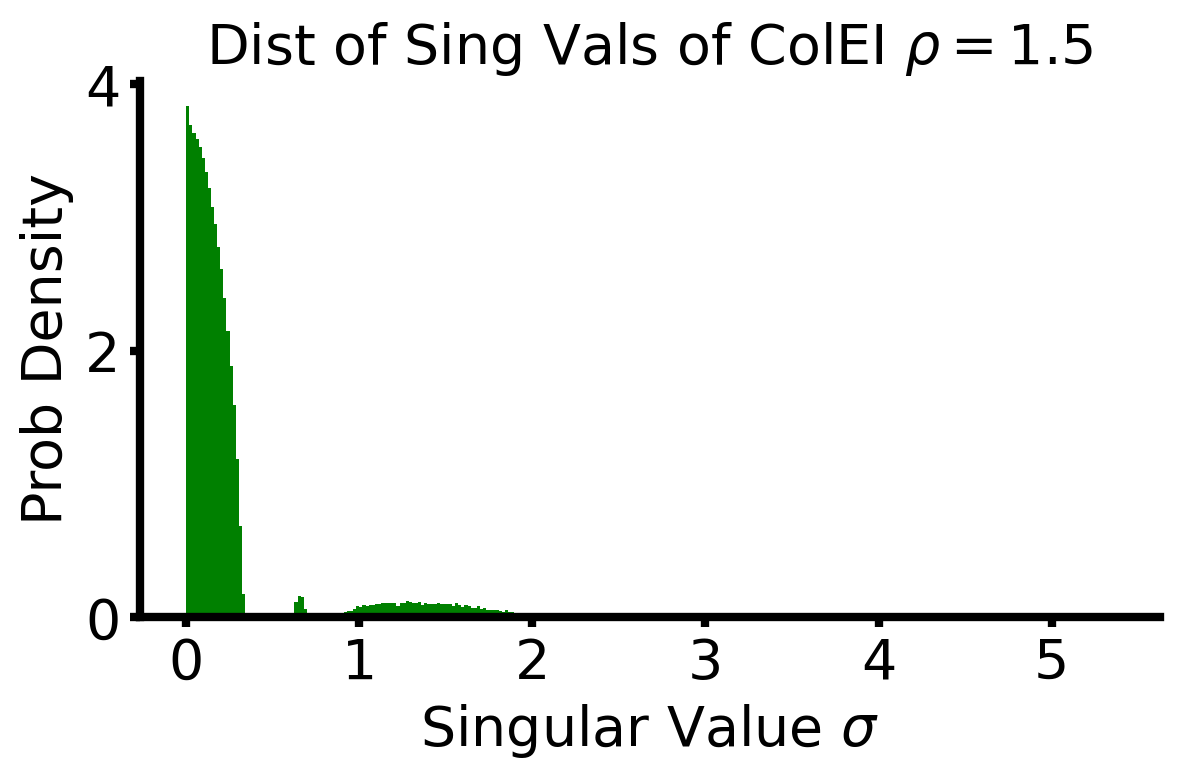

In [6]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (6,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

# plt.yscale('log')
ax.hist(song_sv_before, bins=300, density=True, edgecolor='none', color='g')
ax.set_xlabel(r"Singular Value $\sigma$", fontsize=20)
ax.set_ylabel("Prob Density", fontsize=20)
# ax.set_ylim([0, 1.7])
plt.title(r"Dist of Sing Vals of ColEI $\rho=1.5$", fontsize=20)
# plt.yticks(ticks=[0, 0.8, 1.6], size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.xticks(ticks=[0, 6, 12, 18], size=20)
plt.tight_layout()

# plt.savefig('new_plots/SV_Song_rescale_log.svg', format='svg', dpi=200)
# plt.savefig('new_plots/SV_Song_rescale_log.png', format='png', dpi=200)

plt.show()

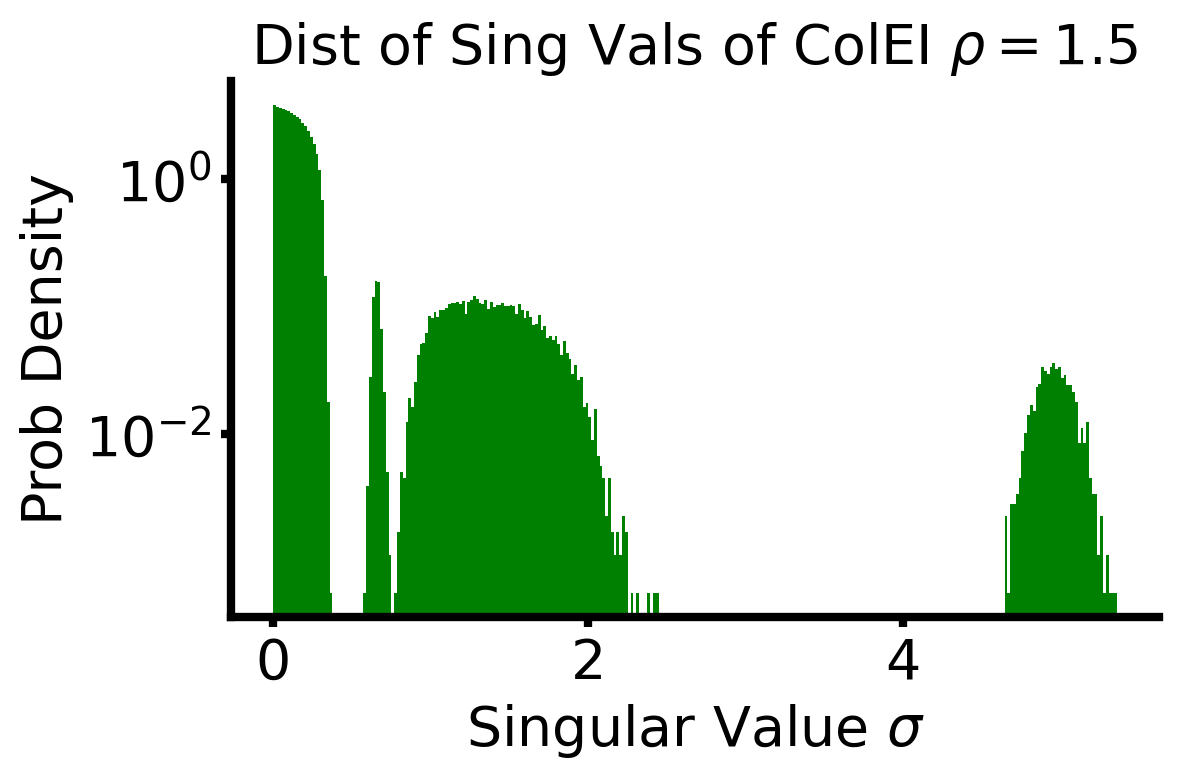

In [7]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (6,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

plt.yscale('log')
ax.hist(song_sv_before, bins=300, density=True, edgecolor='none', color='g')
ax.set_xlabel(r"Singular Value $\sigma$", fontsize=20)
ax.set_ylabel("Prob Density", fontsize=20)
# ax.set_ylim([0, 1.7])
plt.title(r"Dist of Sing Vals of ColEI $\rho=1.5$", fontsize=20)
# plt.yticks(ticks=[0, 0.8, 1.6], size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.xticks(ticks=[0, 6, 12, 18], size=20)
plt.tight_layout()

# plt.savefig('new_plots/SV_Song_rescale_log.svg', format='svg', dpi=200)
# plt.savefig('new_plots/SV_Song_rescale_log.png', format='png', dpi=200)

plt.show()

In [3]:
import imp
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
from argparse import ArgumentParser
import itertools

from lib.dense_layers import DenseLayer, EiDense, ColumnEiDense
from lib.base_rnn import RNNCell 
from lib.model import Model
from lib.dann_rnn import EiRNNCell
from lib.song_rnn import ColumnEiCell
from lib.update_policies import EiRNN_cSGD_UpdatePolicy, DalesANN_cSGD_UpdatePolicy, ColumnEiSGD_Clip, ColumnEiDenseSGD
from lib.init_policies import EiDenseWeightInit_WexMean, W_UniformInit, U_TorchInit, W_TorchInit, ColumnEiCell_W_InitPolicy, ColumnEi_FirstCell_U_InitPolicy, EiRNNCell_U_InitPolicy, EiRNNCell_W_InitPolicy

from lib import utils
from lib import rnn_basic_tasks
from lib.utils import acc_func
from config import PLAYGROUND_DIR
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

In [17]:
sv_entropy = np.zeros((3,5))

n_hidden = 100
n_output_classes = 10

for ind,ei_ratio in enumerate([99, 9, 1]):
    input_features = 28
    n_output_classes  = 10
    for seed in [0,1,2,3,4]:
        utils.set_seed_all(seed)
        cells = [ColumnEiCell(input_features, (n_hidden, ei_ratio),nonlinearity=F.relu, i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(dataset='MNIST'), h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=1.5), update_policy=ColumnEiSGD_Clip()),
                 ColumnEiDense(n_hidden, (n_output_classes, ei_ratio), nonlinearity=None, update_policy=ColumnEiDenseSGD())
                ]
        model = Model(cells)
        rec_weights = model.state_dict()['module_dict.0.W_pos'] @ model.state_dict()['module_dict.0.D_W']
        _, song_sigma, _ = np.linalg.svd(rec_weights)

        sv_entropy[ind,seed] = -(np.log(song_sigma/song_sigma.sum()) * song_sigma/song_sigma.sum()).sum() / np.log(len(song_sigma))
        
sv_entropy = sv_entropy.reshape(-1)

In [18]:
seeds=5
song_rnn = {k: np.zeros((seeds,562)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
transparency = 0.2
song_acc_list = []

leg = ["1%", "10%", "50%"]
for ind, ratio in enumerate([99, 9, 1]):
    for i in [0,1,2,3,4]:
        if ratio == 99: (lr, GC, rad, hidden) = (0.010772, 5, 1.5, 100)
        if ratio == 9: (lr, GC, rad, hidden) = (0.010772, 10, 1.5, 100)
        if ratio == 1: (lr, GC, rad, hidden) = (0.010772, 10, 1.5, 100)
        s = np.load(f'playground/seq_mnist_song_inhib_icml_test/batch_size-32/seed-{i}/song_icml_learning_curves_seed{i}_inhib{ratio}_lr{lr}_GC{GC}.npz')
            
        song_rnn["train_err"][i, :] = s["train_err"]
        song_rnn["test_err"][i, :] = s["test_err"]
        song_rnn["train_loss"][i, :] = s["train_loss"]
        song_rnn["test_loss"][i, :] = s["test_loss"]
        song_rnn["update"][i, :] = s["update"]
        
        song_acc_list.append(s["test_err"][467])

In [ ]:
reg = linregress(sv_entropy, song_acc_list)
print(reg.pvalue, reg.slope)

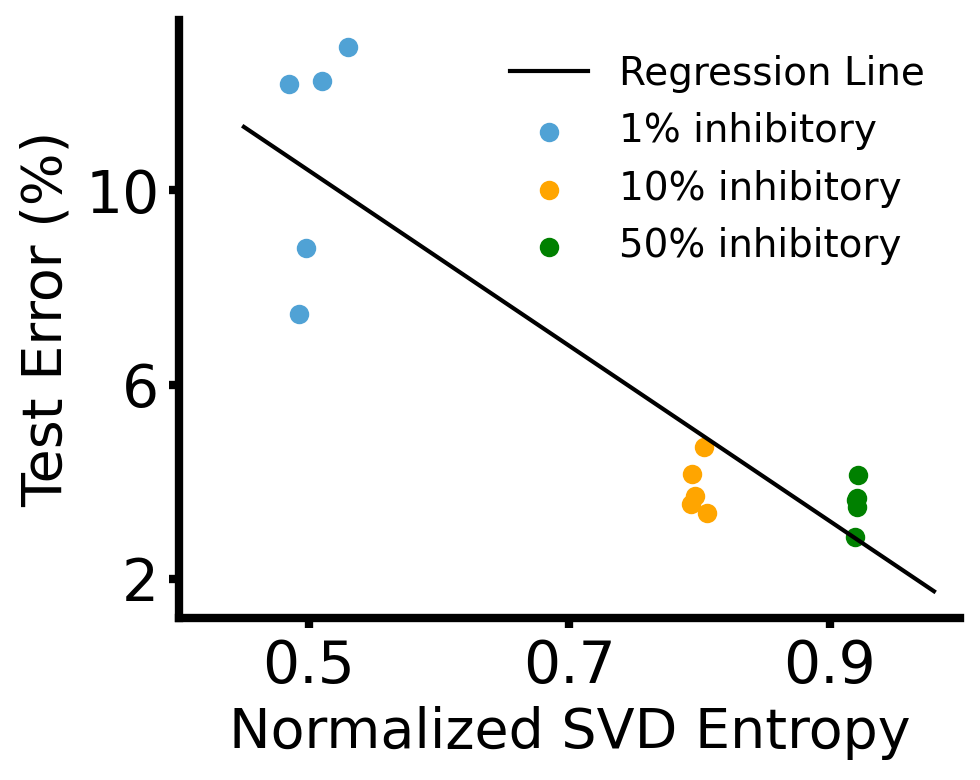

In [31]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (5,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
plt.plot(np.linspace(0.45,.98,num=10000),reg.slope*np.linspace(0.45,.98,num=10000)+reg.intercept,c='k')


plt.scatter(sv_entropy[:5],song_acc_list[:5], color='#50a2d5')
plt.scatter(sv_entropy[5:10],song_acc_list[5:10], color='orange')
plt.scatter(sv_entropy[10:],song_acc_list[10:], color='green')


plt.legend(["Regression Line", "1% inhibitory", "10% inhibitory","50% inhibitory"], fontsize=14, frameon=False)

plt.xlabel(r'Normalized SVD Entropy', fontsize=20)
plt.ylabel('Test Error (%)', fontsize=20)
plt.xlim([0.4, 1])
plt.yticks(ticks=[2, 6, 10], size=21)
plt.xticks(ticks=[0.5, 0.7, 0.9], size=21)
plt.tight_layout()
# plt.savefig('SeqMNIST_Song_Test_Error_vs_SV_Entropy_inhib.png', format='png', dpi=200)
# plt.savefig('SeqMNIST_Song_Test_Error_vs_SV_Entropy_inhib.svg', format='svg', dpi=200)
plt.show()

In [32]:
sv_entropy = np.zeros((3,5))

for ind,n_hidden in enumerate([100, 300, 1000]):
    input_features = 28
    n_output_classes  = 10
    for seed in [0,1,2,3,4]:
        utils.set_seed_all(seed)
        cells = [ColumnEiCell(input_features, (n_hidden, 9),nonlinearity=F.relu, i2h_init_policy=ColumnEi_FirstCell_U_InitPolicy(dataset='MNIST'), h2h_init_policy=ColumnEiCell_W_InitPolicy(radius=1.5), update_policy=ColumnEiSGD_Clip()),
                 ColumnEiDense(n_hidden, (n_output_classes, 9), nonlinearity=None, update_policy=ColumnEiDenseSGD())
                ]
        model = Model(cells)
        rec_weights = model.state_dict()['module_dict.0.W_pos'] @ model.state_dict()['module_dict.0.D_W']
        _, song_sigma, _ = np.linalg.svd(rec_weights)

        sv_entropy[ind,seed] = -(np.log(song_sigma/song_sigma.sum()) * song_sigma/song_sigma.sum()).sum() / np.log(len(song_sigma))
        
sv_entropy = sv_entropy.reshape(-1)

In [33]:
seeds=5
dann_rnn = {k: np.zeros((seeds,1875)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
song_rnn = {k: np.zeros((seeds,1875)) for k in ["test_loss", "test_err", "train_loss", "train_err", "update"]}
transparency = 0.2
song_acc_list = []

leg = ["n=100", "n=300", "n=1000"]
for ind, size in enumerate([100, 300, 1000]):
    for i in [0,1,2,3,4]:
        if size == 100: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 100)
        if size == 300: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 300)
        if size == 1000: (lr, GC, rad, hidden) = (0.015811, 10, 2.0, 1000)
        s = np.load(f'seq_mnist_test_song_shallow_NC/batch_size-32/seed-{i}/song_learning_curves_seed{i}_hidden{hidden}_lr{lr}_GC{GC}_rad{rad}.npz')
            
        song_rnn["train_err"][i, :] = s["train_err"]
        song_rnn["test_err"][i, :] = s["test_err"]
        song_rnn["train_loss"][i, :] = s["train_loss"]
        song_rnn["test_loss"][i, :] = s["test_loss"]
        song_rnn["update"][i, :] = s["update"]
        
        song_acc_list.append(s["test_err"][467])

In [ ]:
reg = linregress(sv_entropy, song_acc_list)

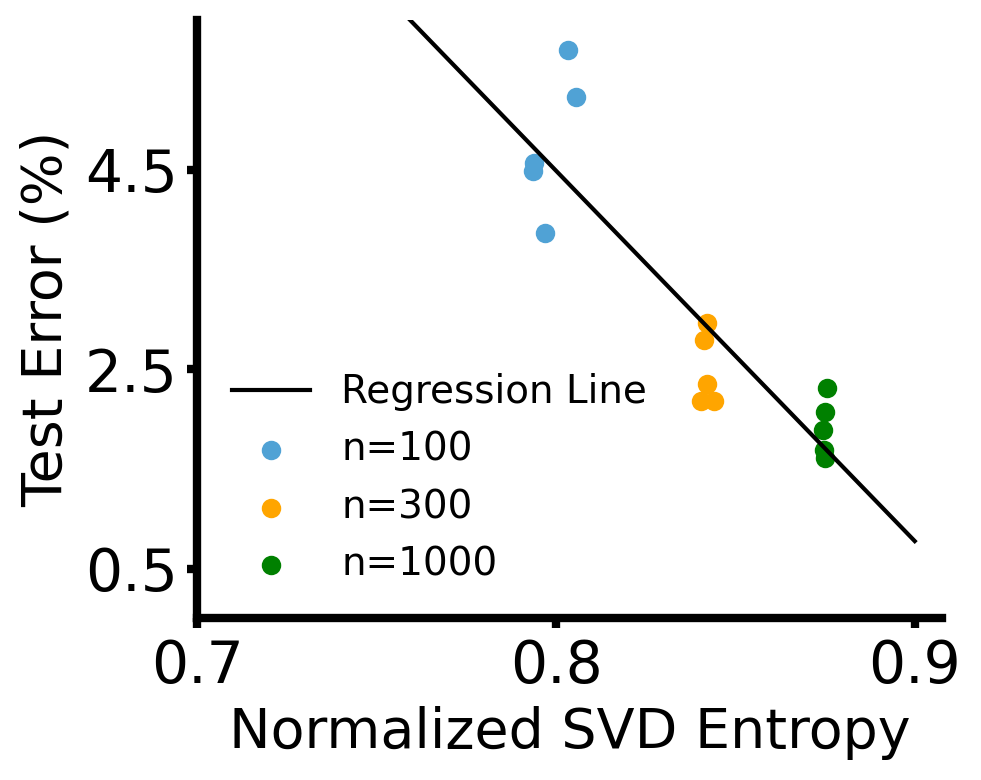

In [35]:
ax = plt.subplot(111)
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams["figure.figsize"] = (5,4)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_linewidth(3)
ax.spines.bottom.set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
plt.plot(np.linspace(0.75,.9,num=10000),reg.slope*np.linspace(.75,.9,num=10000)+reg.intercept,c='k')

plt.scatter(sv_entropy[:5],song_acc_list[:5], color='#50a2d5')
plt.scatter(sv_entropy[5:10],song_acc_list[5:10], color='orange')
plt.scatter(sv_entropy[10:],song_acc_list[10:], color='green')

plt.legend(["Regression Line","n=100", "n=300","n=1000"], fontsize=14, frameon=False)

plt.ylim([0,6])
plt.xlabel(r'Normalized SVD Entropy', fontsize=20)
plt.ylabel('Test Error (%)', fontsize=20)
plt.yticks(ticks=[0.5, 2.5, 4.5], size=21)
plt.xticks(ticks=[0.7, 0.8, 0.9], size=21)
plt.tight_layout()
# plt.savefig('SeqMNIST_Song_Test_Error_vs_SV_Entropy.png', format='png', dpi=200)
# plt.savefig('SeqMNIST_Song_Test_Error_vs_SV_Entropy.svg', format='svg', dpi=200)
plt.show()